## Stage - 3 Team Task

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as sf
import statsmodels.api as smf
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import PolynomialFeatures
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

In [2]:
covid_super_data = pd.read_csv('../../../data/stage_3/covid_large.csv')

In [3]:
covid_super_data.head()

,State,countyFIPS,County Name,Date,Num of Cases,Num of Deaths,population
0,AL,0,statewide unallocated,2020-01-22,0,0,0
1,AL,0,statewide unallocated,2020-01-23,0,0,0
2,AL,0,statewide unallocated,2020-01-24,0,0,0
3,AL,0,statewide unallocated,2020-01-25,0,0,0
4,AL,0,statewide unallocated,2020-01-26,0,0,0


In [4]:
# Calculate the number of new cases per day using diff
covid_super_data["new_cases"] = covid_super_data["Num of Cases"].diff()
covid_super_data["new_death_cases"] = covid_super_data["Num of Deaths"].diff()

In [5]:
covid_super_data.head()

,State,countyFIPS,County Name,Date,Num of Cases,Num of Deaths,population,new_cases,new_death_cases
0,AL,0,statewide unallocated,2020-01-22,0,0,0,NaN,NaN
1,AL,0,statewide unallocated,2020-01-23,0,0,0,0.0,0.0
2,AL,0,statewide unallocated,2020-01-24,0,0,0,0.0,0.0
3,AL,0,statewide unallocated,2020-01-25,0,0,0,0.0,0.0
4,AL,0,statewide unallocated,2020-01-26,0,0,0,0.0,0.0


In [6]:
covid_super_data = covid_super_data[covid_super_data['County Name']!='statewide unallocated']

In [7]:
# Covert Date column from object type to datetime format
covid_super_data['Date'] = covid_super_data.Date.apply(lambda d: datetime.strptime(d, '%Y-%m-%d'))

#### Groupby date and find sum to get the new cases per day 

In [8]:
covid_super_data = covid_super_data.groupby("Date").sum().reset_index()
covid_super_data_new = covid_super_data.drop([0])
covid_super_data_new.head()

,Date,countyFIPS,Num of Cases,Num of Deaths,population,new_cases,new_death_cases
1,2020-01-23,9331435,0,0,122030436,0.0,0.0
2,2020-01-24,9331435,1,0,122030436,1.0,0.0
3,2020-01-25,9331435,1,0,122030436,0.0,0.0
4,2020-01-26,9331435,4,0,122030436,3.0,0.0
5,2020-01-27,9331435,5,0,122030436,1.0,0.0


In [9]:
# new_case_firstday = nc_super_df['new_cases'].astype(int).tolist()
# new_death_case_firstday = nc_super_df['new_death_cases'].astype(int).tolist()

In [10]:
def generate_first_occurance_case(df):
    new_case_firstday = df['new_cases'].astype(int).tolist()
    newcase = next((i for i, j in enumerate(new_case_firstday) if j >0 ), None)
    super_df_firstcase = df.loc[newcase:,['Date','new_cases']]
    # Add a new column num_of_days in an order of index, but starting from 1 to assign x-value i.e 
    # number of days from the first day of infection
    mylist = []
    for i in range(1,(len(super_df_firstcase)+1)):
        mylist.append(i)
    super_df_firstcase['num_of_days'] = mylist
    return super_df_firstcase

In [11]:
def generate_first_occurance_death(df):
    new_death_case_firstday = df['new_death_cases'].astype(int).tolist()
    newcase = next((i for i, j in enumerate(new_death_case_firstday) if j >0 ), None)
    super_df_firstdeath = df.loc[newcase:,['Date','new_death_cases']]
    # Add a new column num_of_days in an order of index, but starting from 1 to assign x-value i.e 
    # number of days from the first day of infection
    mylist = []
    for i in range(1,(len(super_df_firstdeath)+1)):
        mylist.append(i)
    super_df_firstdeath['num_of_days'] = mylist
    return super_df_firstdeath

In [12]:
us_firstcase_df = generate_first_occurance_case(covid_super_data)
us_firstcase_df

,Date,new_cases,num_of_days
2,2020-01-24,1.0,1
3,2020-01-25,0.0,2
4,2020-01-26,3.0,3
5,2020-01-27,1.0,4
6,2020-01-28,0.0,5
...,...,...,...
568,2021-08-12,36781.0,567
569,2021-08-13,191025.0,568
570,2021-08-14,304.0,569
571,2021-08-15,358.0,570


In [13]:
us_firstdeath_df = generate_first_occurance_death(covid_super_data)
us_firstdeath_df

,Date,new_death_cases,num_of_days
15,2020-02-06,1.0,1
16,2020-02-07,0.0,2
17,2020-02-08,0.0,3
18,2020-02-09,0.0,4
19,2020-02-10,0.0,5
...,...,...,...
568,2021-08-12,227.0,554
569,2021-08-13,256.0,555
570,2021-08-14,0.0,556
571,2021-08-15,0.0,557


## Linear regression model

#### Implementing a function for linear model

In [15]:
def generate_model(degree,df,casetype):
    x = df['num_of_days'].astype(int)
    y=""
    y_pred = ""
    model = ""
    x_pred = pd.DataFrame({'num_of_days': np.linspace(df.num_of_days.min(), df.num_of_days.max(), len(df))})
    # Fetching number of cases as per death and new cases dataset
    if(casetype=="new"):
        y = abs(df['new_cases']).astype(int)
    if(casetype=="death"):
        y = abs(df['new_death_cases']).astype(int)
    # Calculating first degree Linear model    
    if(degree==1 and casetype == 'new'):
        model = sf.ols(formula='new_cases ~ num_of_days', data=df).fit()
        y_pred = model.predict(x_pred)
    elif(degree==1 and casetype == 'death'):
        model = sf.ols(formula='new_death_cases ~ num_of_days', data=df).fit()
        y_pred = model.predict(x_pred)    
    # Polynomial regression models - fitting the model to respective degress
    elif(degree>1):
            poly_features = PolynomialFeatures(degree=degree)
            x= smf.add_constant(x_pred)
            x_values = poly_features.fit_transform(x)
            model = smf.OLS(y,x_values).fit()
            y_pred = model.predict(x_values)
    calculate_model_params(model,y,y_pred)        
    return model, y_pred             

In [16]:
def calculate_model_params(model,y_act,y_pred):
    print("RMSE(Root Mean Square Error) value for the Linear model is: ",rmse(y_act,y_pred))

#### Linear Regression model for New Cases

In [17]:
model1, y_pred1 = generate_model(1,us_firstcase_df,"new")
model2, y_pred2 = generate_model(2,us_firstcase_df,"new")
model3, y_pred3 = generate_model(3,us_firstcase_df,"new")
model4, y_pred4 = generate_model(4,us_firstcase_df,"new")
model5, y_pred5 = generate_model(5,us_firstcase_df,"new")

RMSE(Root Mean Square Error) value for the Linear model is:  26480.073891491487
RMSE(Root Mean Square Error) value for the Linear model is:  23849.125479940547
RMSE(Root Mean Square Error) value for the Linear model is:  23833.120625220658
RMSE(Root Mean Square Error) value for the Linear model is:  21513.87060297577
RMSE(Root Mean Square Error) value for the Linear model is:  19207.47527320468


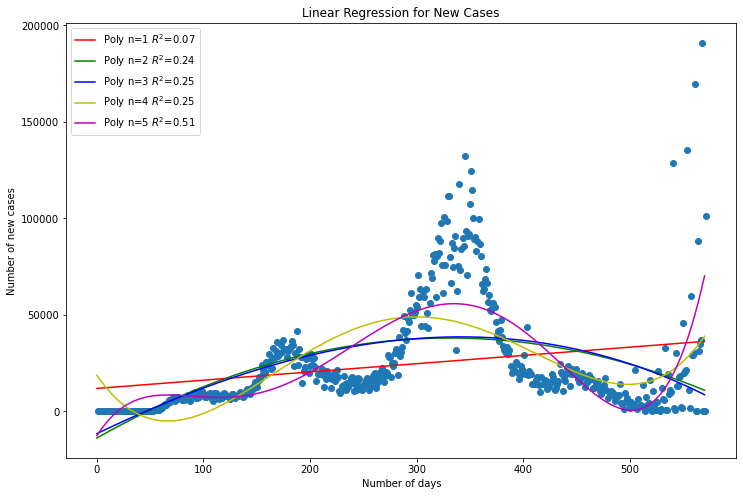

In [18]:
plt. figure(figsize=(12,8))
plt.scatter(us_firstcase_df['num_of_days'],abs(us_firstcase_df['new_cases']))
plt.plot(y_pred1,c='r',label='Poly n=1 $R^2$=%.2f' % model1.rsquared, alpha=1.0)
plt.plot(y_pred2,c='g',label='Poly n=2 $R^2$=%.2f' % model2.rsquared, alpha=1.0)
plt.plot(y_pred3,c='b',label='Poly n=3 $R^2$=%.2f' % model3.rsquared, alpha=1.0)
plt.plot(y_pred4,c='y',label='Poly n=4 $R^2$=%.2f' % model3.rsquared, alpha=1.0)
plt.plot(y_pred5,c='m',label='Poly n=5 $R^2$=%.2f' % model5.rsquared, alpha=1.0)
plt.title("Linear Regression for New Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of new cases")
plt.legend()
plt.show("png")

#### Linear Regression model for Death cases

In [19]:
model_death1, y_pred_d1 = generate_model(1,us_firstdeath_df,"death")
model_death2, y_pred_d2 = generate_model(2,us_firstdeath_df,"death")
model_death3, y_pred_d3 = generate_model(3,us_firstdeath_df,"death")
model_death4, y_pred_d4 = generate_model(4,us_firstdeath_df,"death")
model_death5, y_pred_d5 = generate_model(5,us_firstdeath_df,"death")

RMSE(Root Mean Square Error) value for the Linear model is:  427.4320108943231
RMSE(Root Mean Square Error) value for the Linear model is:  372.119108055281
RMSE(Root Mean Square Error) value for the Linear model is:  363.2467756580691
RMSE(Root Mean Square Error) value for the Linear model is:  362.7617121773844
RMSE(Root Mean Square Error) value for the Linear model is:  330.89181505859733


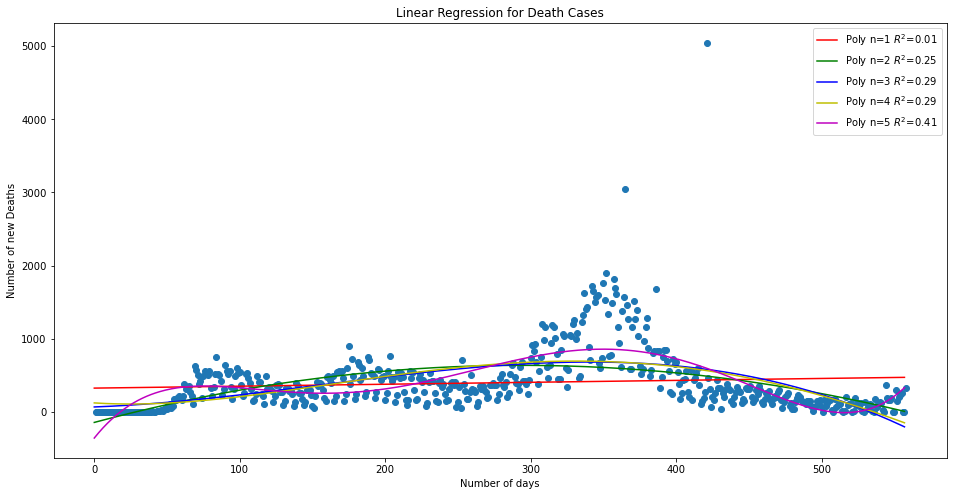

In [20]:
plt. figure(figsize=(16,8))
plt.scatter(us_firstdeath_df['num_of_days'],abs(us_firstdeath_df['new_death_cases']))
plt.plot(y_pred_d1,c='r',label='Poly n=1 $R^2$=%.2f' % model_death1.rsquared, alpha=1.0)
plt.plot(y_pred_d2,c='g',label='Poly n=2 $R^2$=%.2f' % model_death2.rsquared, alpha=1.0)
plt.plot(y_pred_d3,c='b',label='Poly n=3 $R^2$=%.2f' % model_death3.rsquared, alpha=1.0)
plt.plot(y_pred_d4,c='y',label='Poly n=4 $R^2$=%.2f' % model_death4.rsquared, alpha=1.0)
plt.plot(y_pred_d5,c='m',label='Poly n=5 $R^2$=%.2f' % model_death5.rsquared, alpha=1.0)
plt.title("Linear Regression for Death Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of new Deaths")
plt.legend()
plt.show("png")

#### From the rsquared line(red) we generated above is definitely not a Linear model. There is some dependency between number of days and number of new cases. But, it is not linear. This is where Polynomial or non-linear modelling is useful to find a best fit regression line.

### Bias vs Variance tradeoff

For the cases model, the polynomial regression model has more error than the linear regression model therefore using a high bias, low vairance model is better here.

For the deaths model, the polynomial regression model has more error than the linear regression model therefore using a high bias, low vairance model is better here.


## Plot the trend lines for US new cases

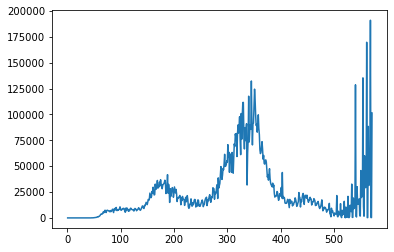

In [21]:
plt.plot(us_firstcase_df['num_of_days'],abs(us_firstcase_df['new_cases']))

## Plot the trend lines for US new death cases

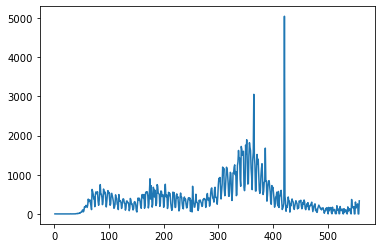

In [22]:
plt.plot(us_firstdeath_df['num_of_days'],abs(us_firstdeath_df['new_death_cases']))

## Plot a trend line for next one week prediction for covid-19 new cases in United States

In [23]:
# calculate the next 7 days input to x-axis and feed it to the model
def calculate_future_days(df):
    future_days = []
    future_days_df = ""
    for days in range((len(df)+1),(len(df)+7)):
        future_days.append(days)
        future_days_df = pd.DataFrame(future_days,columns=['num_of_days']) 
    return future_days_df

In [24]:
future_days_df = calculate_future_days(us_firstcase_df)

In [25]:
predict_newcases_us = model1.predict(future_days_df['num_of_days'])

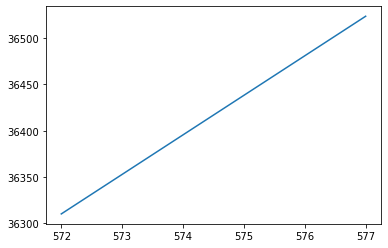

In [26]:
plt.plot(future_days_df['num_of_days'],predict_newcases_us)

## Plot a trend line for next one week prediction for covid-19 new cases in United States

In [27]:
predict_newcases_us_death = model_death1.predict(future_days_df['num_of_days'])

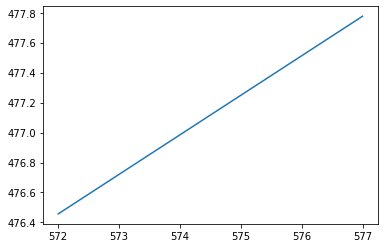

In [28]:
plt.plot(future_days_df['num_of_days'],predict_newcases_us_death)

## Implementing Linear and Non linear regression for Other countries

In [29]:
# Getting data from the same countries that are selected in stage-2
foreign_countries = pd.read_csv('../../../data/stage_3/owid-covid-data.csv')
foreign_countries = foreign_countries[foreign_countries["location"].isin(["Indonesia", "Brazil", "Nigeria", "Russia", "Japan"])]

foreign_countries = foreign_countries[["location","date","new_cases","new_deaths","population"]]
# Removing 'Nan' values
foreign_countries['new_cases'] = foreign_countries['new_cases'].fillna(0) 
foreign_countries['new_deaths'] = foreign_countries['new_deaths'].fillna(0) 
foreign_countries = foreign_countries.rename(columns = {'new_deaths':'new_death_cases','date':'Date'})

### Indonesia

In [30]:
indonesia_data = foreign_countries[foreign_countries["location"] == "Indonesia"].reset_index()
indonesia_data

,index,location,Date,new_cases,new_death_cases,population
0,51714,Indonesia,2020-03-02,2.0,0.0,276361788.0
1,51715,Indonesia,2020-03-03,0.0,0.0,276361788.0
2,51716,Indonesia,2020-03-04,0.0,0.0,276361788.0
3,51717,Indonesia,2020-03-05,0.0,0.0,276361788.0
4,51718,Indonesia,2020-03-06,2.0,0.0,276361788.0
...,...,...,...,...,...,...
587,52301,Indonesia,2021-10-10,894.0,39.0,276361788.0
588,52302,Indonesia,2021-10-11,620.0,65.0,276361788.0
589,52303,Indonesia,2021-10-12,1261.0,47.0,276361788.0
590,52304,Indonesia,2021-10-13,1233.0,48.0,276361788.0


In [31]:
id_firstcase_df = generate_first_occurance_case(indonesia_data)
id_firstcase_df

,Date,new_cases,num_of_days
0,2020-03-02,2.0,1
1,2020-03-03,0.0,2
2,2020-03-04,0.0,3
3,2020-03-05,0.0,4
4,2020-03-06,2.0,5
...,...,...,...
587,2021-10-10,894.0,588
588,2021-10-11,620.0,589
589,2021-10-12,1261.0,590
590,2021-10-13,1233.0,591


In [32]:
id_firstdeath_df = generate_first_occurance_death(indonesia_data)
id_firstdeath_df

,Date,new_death_cases,num_of_days
9,2020-03-11,1.0,1
10,2020-03-12,0.0,2
11,2020-03-13,3.0,3
12,2020-03-14,1.0,4
13,2020-03-15,0.0,5
...,...,...,...
587,2021-10-10,39.0,579
588,2021-10-11,65.0,580
589,2021-10-12,47.0,581
590,2021-10-13,48.0,582


##### New Cases

RMSE(Root Mean Square Error) value for the Linear model is:  8208.60850428662
RMSE(Root Mean Square Error) value for the Linear model is:  8207.792200563745
RMSE(Root Mean Square Error) value for the Linear model is:  8009.5398357477325
RMSE(Root Mean Square Error) value for the Linear model is:  7511.608093766497
RMSE(Root Mean Square Error) value for the Linear model is:  6635.5524720721205


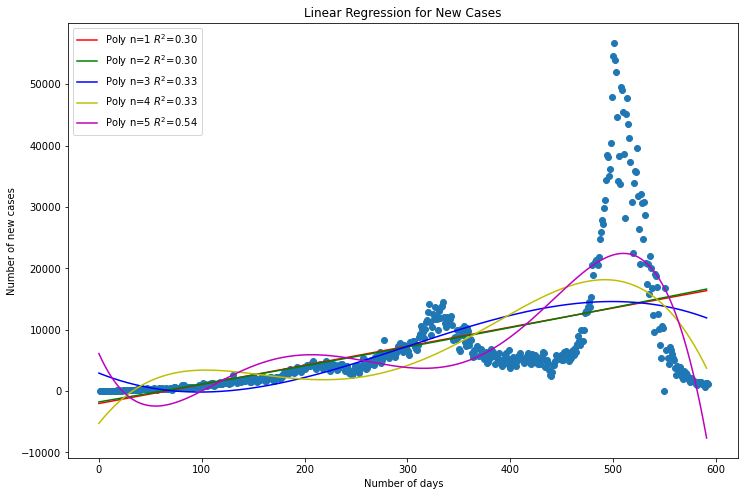

In [33]:
# Linear Regression for New cases
model1, y_pred1 = generate_model(1,id_firstcase_df,"new")
model2, y_pred2 = generate_model(2,id_firstcase_df,"new")
model3, y_pred3 = generate_model(3,id_firstcase_df,"new")
model4, y_pred4 = generate_model(4,id_firstcase_df,"new")
model5, y_pred5 = generate_model(5,id_firstcase_df,"new")

# Plotting Figure
plt. figure(figsize=(12,8))
plt.scatter(id_firstcase_df['num_of_days'],abs(id_firstcase_df['new_cases']))
plt.plot(y_pred1,c='r',label='Poly n=1 $R^2$=%.2f' % model1.rsquared, alpha=1.0)
plt.plot(y_pred2,c='g',label='Poly n=2 $R^2$=%.2f' % model2.rsquared, alpha=1.0)
plt.plot(y_pred3,c='b',label='Poly n=3 $R^2$=%.2f' % model3.rsquared, alpha=1.0)
plt.plot(y_pred4,c='y',label='Poly n=4 $R^2$=%.2f' % model3.rsquared, alpha=1.0)
plt.plot(y_pred5,c='m',label='Poly n=5 $R^2$=%.2f' % model5.rsquared, alpha=1.0)
plt.title("Linear Regression for New Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of new cases")
plt.legend()
plt.show("png")

##### New Deaths

RMSE(Root Mean Square Error) value for the Linear model is:  311.06105985430736
RMSE(Root Mean Square Error) value for the Linear model is:  305.0262321150431
RMSE(Root Mean Square Error) value for the Linear model is:  303.612207530457
RMSE(Root Mean Square Error) value for the Linear model is:  283.56205203841927
RMSE(Root Mean Square Error) value for the Linear model is:  241.43171782885454


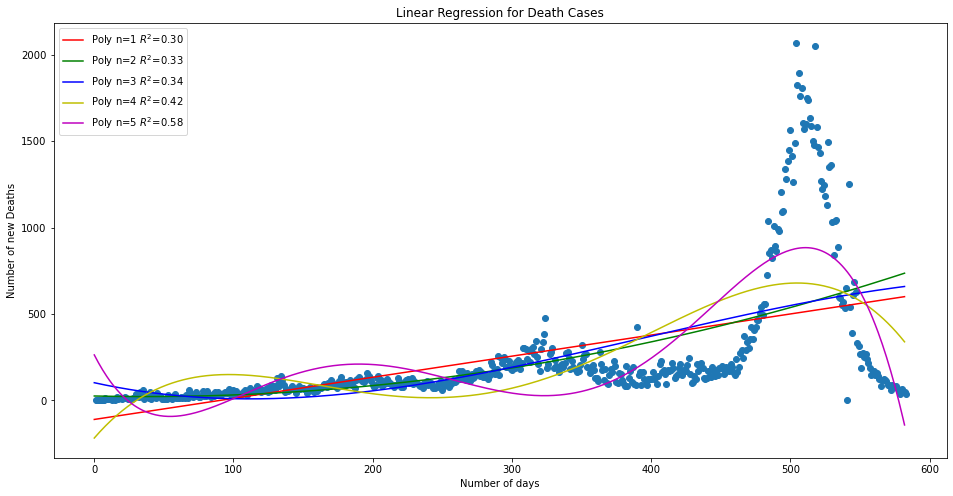

In [34]:
# Linear Regression for new deaths
model_death1, y_pred_d1 = generate_model(1,id_firstdeath_df,"death")
model_death2, y_pred_d2 = generate_model(2,id_firstdeath_df,"death")
model_death3, y_pred_d3 = generate_model(3,id_firstdeath_df,"death")
model_death4, y_pred_d4 = generate_model(4,id_firstdeath_df,"death")
model_death5, y_pred_d5 = generate_model(5,id_firstdeath_df,"death")

# Plotting Figure
plt. figure(figsize=(16,8))
plt.scatter(id_firstdeath_df['num_of_days'],abs(id_firstdeath_df['new_death_cases']))
plt.plot(y_pred_d1,c='r',label='Poly n=1 $R^2$=%.2f' % model_death1.rsquared, alpha=1.0)
plt.plot(y_pred_d2,c='g',label='Poly n=2 $R^2$=%.2f' % model_death2.rsquared, alpha=1.0)
plt.plot(y_pred_d3,c='b',label='Poly n=3 $R^2$=%.2f' % model_death3.rsquared, alpha=1.0)
plt.plot(y_pred_d4,c='y',label='Poly n=4 $R^2$=%.2f' % model_death4.rsquared, alpha=1.0)
plt.plot(y_pred_d5,c='m',label='Poly n=5 $R^2$=%.2f' % model_death5.rsquared, alpha=1.0)
plt.title("Linear Regression for Death Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of new Deaths")
plt.legend()
plt.show("png")

### Trend lines for new cases and deaths in indonesia

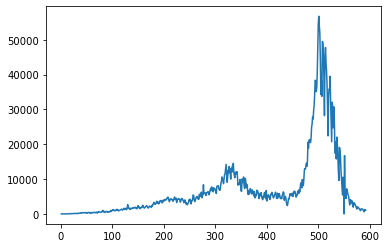

In [35]:
plt.plot(id_firstcase_df['num_of_days'],abs(id_firstcase_df['new_cases']))

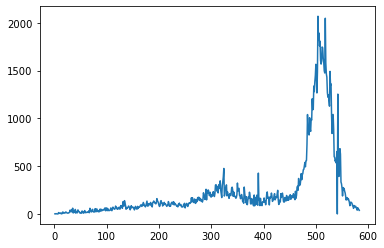

In [36]:
plt.plot(id_firstdeath_df['num_of_days'],abs(id_firstdeath_df['new_death_cases']))

### Plotting a trend line for next one week prediction of new cases in Indonesia

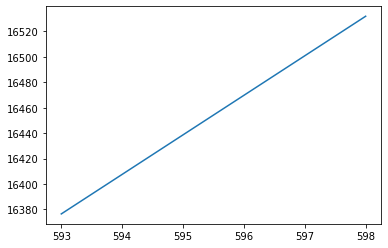

In [37]:
future_days_df = calculate_future_days(id_firstcase_df)
predict_newcases_indonesia = model1.predict(future_days_df['num_of_days'])
plt.plot(future_days_df['num_of_days'],predict_newcases_indonesia)

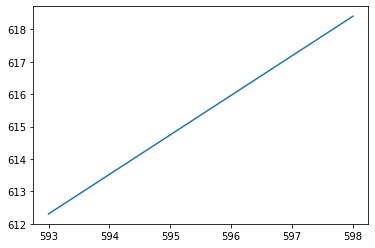

In [38]:
predict_newcases_us_death = model_death1.predict(future_days_df['num_of_days'])
plt.plot(future_days_df['num_of_days'],predict_newcases_us_death)

### Brazil

In [39]:
brazil_data = foreign_countries[foreign_countries["location"] == "Brazil"].reset_index()

In [40]:
br_first_case = generate_first_occurance_case(brazil_data)
br_first_case

,Date,new_cases,num_of_days
0,2020-02-26,1.0,1
1,2020-02-27,0.0,2
2,2020-02-28,0.0,3
3,2020-02-29,1.0,4
4,2020-03-01,0.0,5
...,...,...,...
592,2021-10-10,8639.0,593
593,2021-10-11,6918.0,594
594,2021-10-12,7359.0,595
595,2021-10-13,7852.0,596


In [41]:
br_first_deathcase = generate_first_occurance_death(brazil_data)
br_first_deathcase

,Date,new_death_cases,num_of_days
20,2020-03-17,1.0,1
21,2020-03-18,2.0,2
22,2020-03-19,3.0,3
23,2020-03-20,5.0,4
24,2020-03-21,4.0,5
...,...,...,...
592,2021-10-10,182.0,573
593,2021-10-11,202.0,574
594,2021-10-12,185.0,575
595,2021-10-13,176.0,576


RMSE(Root Mean Square Error) value for the Linear model is:  23083.645033425546
RMSE(Root Mean Square Error) value for the Linear model is:  19068.420931510293
RMSE(Root Mean Square Error) value for the Linear model is:  17992.58083190733
RMSE(Root Mean Square Error) value for the Linear model is:  17018.3791967776
RMSE(Root Mean Square Error) value for the Linear model is:  16791.264372537193


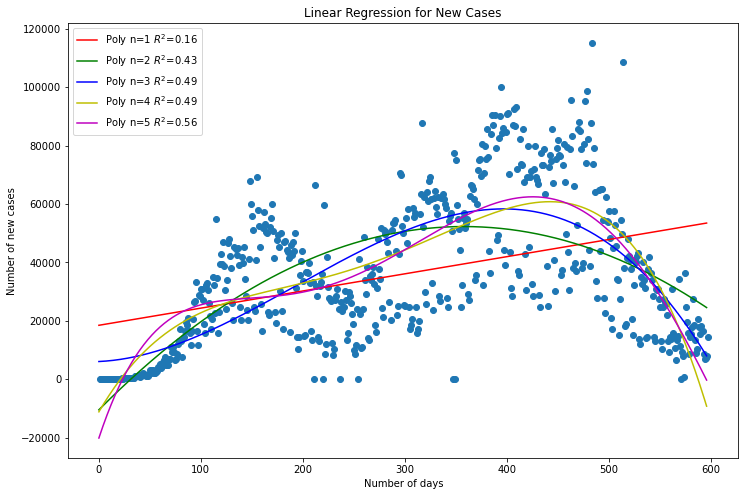

In [42]:
# Linear Regression for New cases
model1, y_pred1 = generate_model(1,br_first_case,"new")
model2, y_pred2 = generate_model(2,br_first_case,"new")
model3, y_pred3 = generate_model(3,br_first_case,"new")
model4, y_pred4 = generate_model(4,br_first_case,"new")
model5, y_pred5 = generate_model(5,br_first_case,"new")

# Plotting figure
plt. figure(figsize=(12,8))
plt.scatter(br_first_case['num_of_days'],abs(br_first_case['new_cases']))
plt.plot(y_pred1,c='r',label='Poly n=1 $R^2$=%.2f' % model1.rsquared, alpha=1.0)
plt.plot(y_pred2,c='g',label='Poly n=2 $R^2$=%.2f' % model2.rsquared, alpha=1.0)
plt.plot(y_pred3,c='b',label='Poly n=3 $R^2$=%.2f' % model3.rsquared, alpha=1.0)
plt.plot(y_pred4,c='y',label='Poly n=4 $R^2$=%.2f' % model3.rsquared, alpha=1.0)
plt.plot(y_pred5,c='m',label='Poly n=5 $R^2$=%.2f' % model5.rsquared, alpha=1.0)
plt.title("Linear Regression for New Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of new cases")
plt.legend()
plt.show("png")

RMSE(Root Mean Square Error) value for the Linear model is:  755.0392458901913
RMSE(Root Mean Square Error) value for the Linear model is:  707.7450809727944
RMSE(Root Mean Square Error) value for the Linear model is:  647.8739565519361
RMSE(Root Mean Square Error) value for the Linear model is:  588.4464355742072
RMSE(Root Mean Square Error) value for the Linear model is:  528.1440391907412


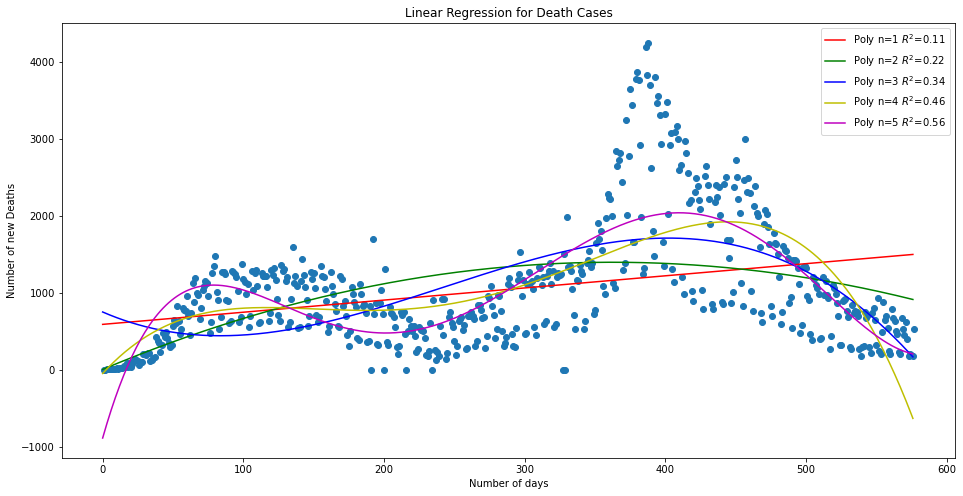

In [43]:
# Linear Regression for new deaths
model_death1, y_pred_d1 = generate_model(1,br_first_deathcase,"death")
model_death2, y_pred_d2 = generate_model(2,br_first_deathcase,"death")
model_death3, y_pred_d3 = generate_model(3,br_first_deathcase,"death")
model_death4, y_pred_d4 = generate_model(4,br_first_deathcase,"death")
model_death5, y_pred_d5 = generate_model(5,br_first_deathcase,"death")

# Plotting Figure
plt. figure(figsize=(16,8))
plt.scatter(br_first_deathcase['num_of_days'],abs(br_first_deathcase['new_death_cases']))
plt.plot(y_pred_d1,c='r',label='Poly n=1 $R^2$=%.2f' % model_death1.rsquared, alpha=1.0)
plt.plot(y_pred_d2,c='g',label='Poly n=2 $R^2$=%.2f' % model_death2.rsquared, alpha=1.0)
plt.plot(y_pred_d3,c='b',label='Poly n=3 $R^2$=%.2f' % model_death3.rsquared, alpha=1.0)
plt.plot(y_pred_d4,c='y',label='Poly n=4 $R^2$=%.2f' % model_death4.rsquared, alpha=1.0)
plt.plot(y_pred_d5,c='m',label='Poly n=5 $R^2$=%.2f' % model_death5.rsquared, alpha=1.0)
plt.title("Linear Regression for Death Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of new Deaths")
plt.legend()
plt.show("png")

### Trend lines for new cases and deaths in brazil

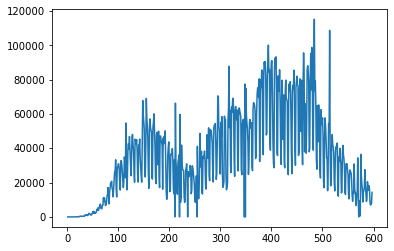

In [44]:
plt.plot(br_first_case['num_of_days'],abs(br_first_case['new_cases']))

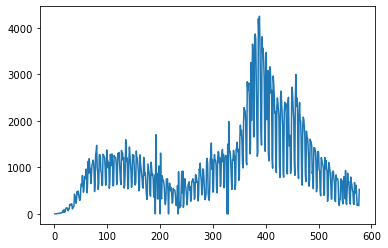

In [45]:
plt.plot(br_first_deathcase['num_of_days'],abs(br_first_deathcase['new_death_cases']))

#### Plotting a trend line for next one week prediction of new cases in brazil

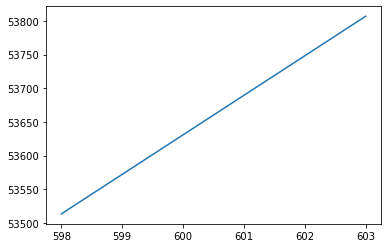

In [46]:
future_days_br = calculate_future_days(br_first_case)
predict_newcases_brazil = model1.predict(future_days_br['num_of_days'])
plt.plot(future_days_br['num_of_days'],predict_newcases_brazil)

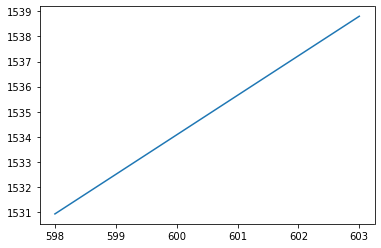

In [47]:
predict_newcases_br_death = model_death1.predict(future_days_br['num_of_days'])
plt.plot(future_days_br['num_of_days'],predict_newcases_br_death)

## Nigeria

In [48]:
nigeria_data = foreign_countries[foreign_countries["location"] == "Nigeria"].reset_index()

In [49]:
ni_firstcase = generate_first_occurance_case(nigeria_data)

In [50]:
ni_firstdeath_case = generate_first_occurance_death(nigeria_data)

RMSE(Root Mean Square Error) value for the Linear model is:  386.57212609439
RMSE(Root Mean Square Error) value for the Linear model is:  371.99992253209416
RMSE(Root Mean Square Error) value for the Linear model is:  366.328736265068
RMSE(Root Mean Square Error) value for the Linear model is:  361.4912845943872
RMSE(Root Mean Square Error) value for the Linear model is:  357.717600552041


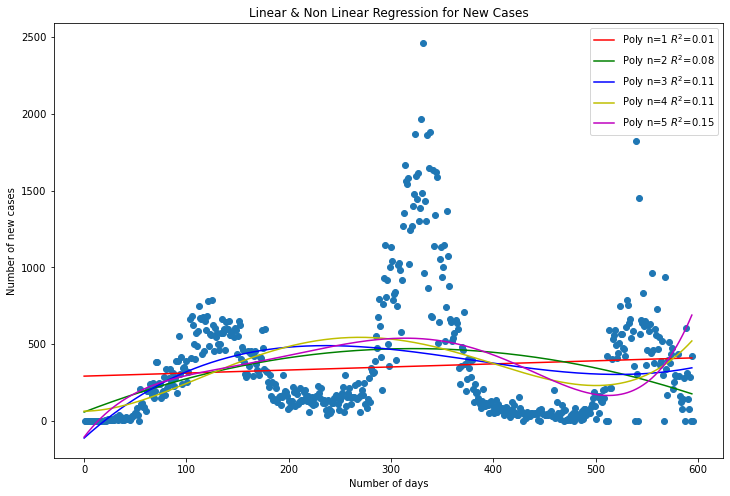

In [51]:
# Linear Regression for New cases
model1, y_pred1 = generate_model(1,ni_firstcase,"new")
model2, y_pred2 = generate_model(2,ni_firstcase,"new")
model3, y_pred3 = generate_model(3,ni_firstcase,"new")
model4, y_pred4 = generate_model(4,ni_firstcase,"new")
model5, y_pred5 = generate_model(5,ni_firstcase,"new")

# Plotting figure
plt. figure(figsize=(12,8))
plt.scatter(ni_firstcase['num_of_days'],abs(ni_firstcase['new_cases']))
plt.plot(y_pred1,c='r',label='Poly n=1 $R^2$=%.2f' % model1.rsquared, alpha=1.0)
plt.plot(y_pred2,c='g',label='Poly n=2 $R^2$=%.2f' % model2.rsquared, alpha=1.0)
plt.plot(y_pred3,c='b',label='Poly n=3 $R^2$=%.2f' % model3.rsquared, alpha=1.0)
plt.plot(y_pred4,c='y',label='Poly n=4 $R^2$=%.2f' % model3.rsquared, alpha=1.0)
plt.plot(y_pred5,c='m',label='Poly n=5 $R^2$=%.2f' % model5.rsquared, alpha=1.0)
plt.title("Linear & Non Linear Regression for New Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of new cases")
plt.legend()
plt.show("png")

RMSE(Root Mean Square Error) value for the Linear model is:  7.040665746422596
RMSE(Root Mean Square Error) value for the Linear model is:  7.023702614965189
RMSE(Root Mean Square Error) value for the Linear model is:  6.932002745064169
RMSE(Root Mean Square Error) value for the Linear model is:  6.926708490864998
RMSE(Root Mean Square Error) value for the Linear model is:  6.805065083200882


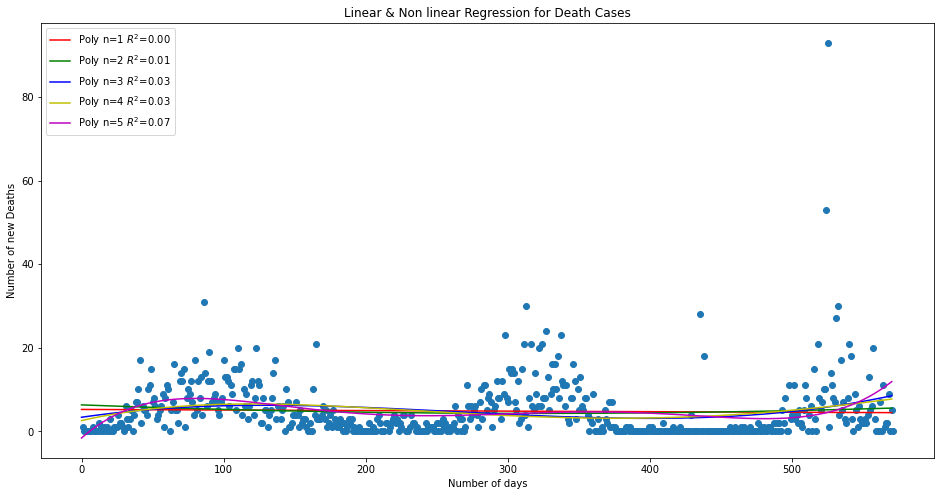

In [52]:
# Linear Regression for new deaths
model_death1, y_pred_d1 = generate_model(1,ni_firstdeath_case,"death")
model_death2, y_pred_d2 = generate_model(2,ni_firstdeath_case,"death")
model_death3, y_pred_d3 = generate_model(3,ni_firstdeath_case,"death")
model_death4, y_pred_d4 = generate_model(4,ni_firstdeath_case,"death")
model_death5, y_pred_d5 = generate_model(5,ni_firstdeath_case,"death")

# Plotting Figure
plt. figure(figsize=(16,8))
plt.scatter(ni_firstdeath_case['num_of_days'],abs(ni_firstdeath_case['new_death_cases']))
plt.plot(y_pred_d1,c='r',label='Poly n=1 $R^2$=%.2f' % model_death1.rsquared, alpha=1.0)
plt.plot(y_pred_d2,c='g',label='Poly n=2 $R^2$=%.2f' % model_death2.rsquared, alpha=1.0)
plt.plot(y_pred_d3,c='b',label='Poly n=3 $R^2$=%.2f' % model_death3.rsquared, alpha=1.0)
plt.plot(y_pred_d4,c='y',label='Poly n=4 $R^2$=%.2f' % model_death4.rsquared, alpha=1.0)
plt.plot(y_pred_d5,c='m',label='Poly n=5 $R^2$=%.2f' % model_death5.rsquared, alpha=1.0)
plt.title("Linear & Non linear Regression for Death Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of new Deaths")
plt.legend()
plt.show("png")

#### Trend line for new cases and deaths in Nigeria

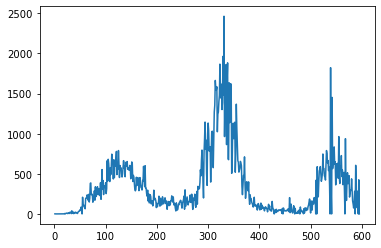

In [53]:
plt.plot(ni_firstcase['num_of_days'],abs(ni_firstcase['new_cases']))

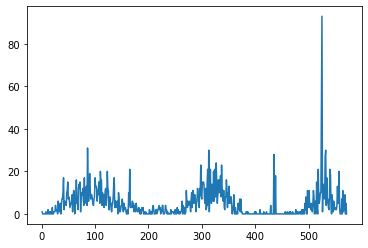

In [54]:
plt.plot(ni_firstdeath_case['num_of_days'],abs(ni_firstdeath_case['new_death_cases']))

#### Plotting a trend line for next one week prediction of new cases in Nigeria

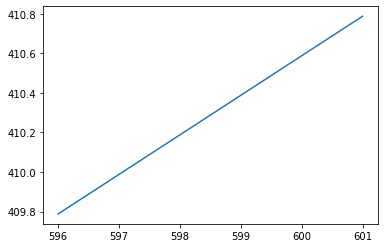

In [55]:
future_days_ng = calculate_future_days(ni_firstcase)
predict_newcases_nigeria = model1.predict(future_days_ng['num_of_days'])
plt.plot(future_days_ng['num_of_days'],predict_newcases_nigeria)

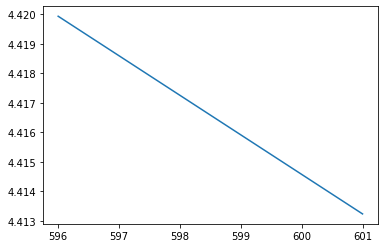

In [56]:
predict_newcases_ng_death = model_death1.predict(future_days_ng['num_of_days'])
plt.plot(future_days_ng['num_of_days'],predict_newcases_ng_death)

## Russia

In [57]:
russia_data = foreign_countries[foreign_countries["location"] == "Russia"].reset_index()

In [58]:
ru_new_death_cases = generate_first_occurance_death(russia_data)
ru_new_death_cases

,Date,new_death_cases,num_of_days
48,2020-03-19,1.0,1
49,2020-03-20,0.0,2
50,2020-03-21,0.0,3
51,2020-03-22,0.0,4
52,2020-03-23,0.0,5
...,...,...,...
618,2021-10-10,949.0,571
619,2021-10-11,946.0,572
620,2021-10-12,954.0,573
621,2021-10-13,962.0,574


In [59]:
ru_new_cases =generate_first_occurance_case(russia_data)
ru_new_cases

,Date,new_cases,num_of_days
0,2020-01-31,2.0,1
1,2020-02-01,0.0,2
2,2020-02-02,0.0,3
3,2020-02-03,0.0,4
4,2020-02-04,0.0,5
...,...,...,...
618,2021-10-10,27889.0,619
619,2021-10-11,28636.0,620
620,2021-10-12,27414.0,621
621,2021-10-13,27926.0,622


RMSE(Root Mean Square Error) value for the Linear model is:  6151.094417557013
RMSE(Root Mean Square Error) value for the Linear model is:  5974.8365577064615
RMSE(Root Mean Square Error) value for the Linear model is:  5765.120135244349
RMSE(Root Mean Square Error) value for the Linear model is:  5362.628205617264
RMSE(Root Mean Square Error) value for the Linear model is:  5362.618557979711


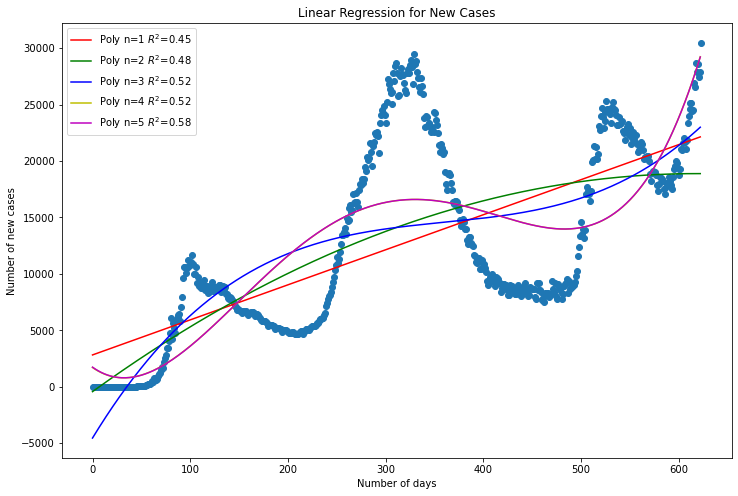

In [60]:
# Linear Regression for New cases
model1, y_pred1 = generate_model(1,ru_new_cases,"new")
model2, y_pred2 = generate_model(2,ru_new_cases,"new")
model3, y_pred3 = generate_model(3,ru_new_cases,"new")
model4, y_pred4 = generate_model(4,ru_new_cases,"new")
model5, y_pred5 = generate_model(5,ru_new_cases,"new")

# Plotting figure
plt. figure(figsize=(12,8))
plt.scatter(ru_new_cases['num_of_days'],abs(ru_new_cases['new_cases']))
plt.plot(y_pred1,c='r',label='Poly n=1 $R^2$=%.2f' % model1.rsquared, alpha=1.0)
plt.plot(y_pred2,c='g',label='Poly n=2 $R^2$=%.2f' % model2.rsquared, alpha=1.0)
plt.plot(y_pred3,c='b',label='Poly n=3 $R^2$=%.2f' % model3.rsquared, alpha=1.0)
plt.plot(y_pred4,c='y',label='Poly n=4 $R^2$=%.2f' % model3.rsquared, alpha=1.0)
plt.plot(y_pred5,c='m',label='Poly n=5 $R^2$=%.2f' % model5.rsquared, alpha=1.0)
plt.title("Linear Regression for New Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of new cases")
plt.legend()
plt.show("png")

RMSE(Root Mean Square Error) value for the Linear model is:  113.49236652285919
RMSE(Root Mean Square Error) value for the Linear model is:  111.0110346450651
RMSE(Root Mean Square Error) value for the Linear model is:  106.21137480311015
RMSE(Root Mean Square Error) value for the Linear model is:  98.99303243820559
RMSE(Root Mean Square Error) value for the Linear model is:  98.8746995470764


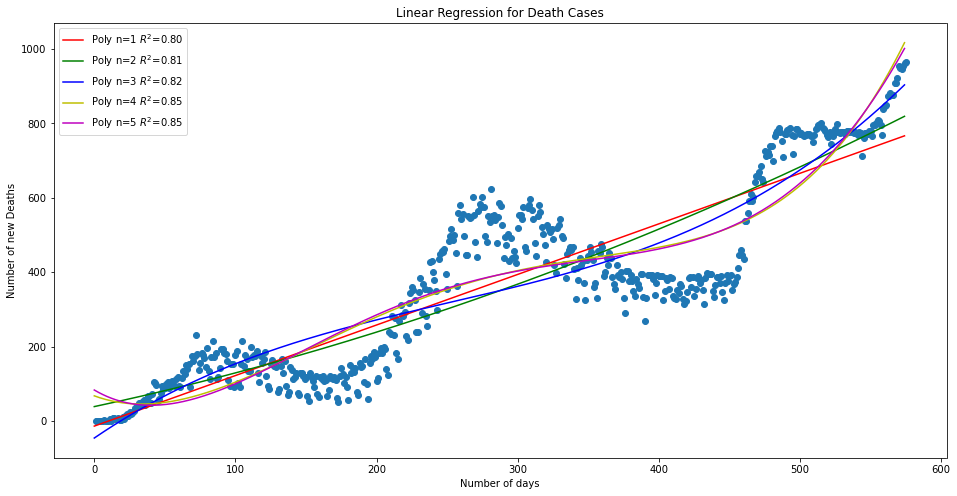

In [61]:
# Linear Regression for new deaths
model_death1, y_pred_d1 = generate_model(1,ru_new_death_cases,"death")
model_death2, y_pred_d2 = generate_model(2,ru_new_death_cases,"death")
model_death3, y_pred_d3 = generate_model(3,ru_new_death_cases,"death")
model_death4, y_pred_d4 = generate_model(4,ru_new_death_cases,"death")
model_death5, y_pred_d5 = generate_model(5,ru_new_death_cases,"death")

# Plotting Figure
plt. figure(figsize=(16,8))
plt.scatter(ru_new_death_cases['num_of_days'],abs(ru_new_death_cases['new_death_cases']))
plt.plot(y_pred_d1,c='r',label='Poly n=1 $R^2$=%.2f' % model_death1.rsquared, alpha=1.0)
plt.plot(y_pred_d2,c='g',label='Poly n=2 $R^2$=%.2f' % model_death2.rsquared, alpha=1.0)
plt.plot(y_pred_d3,c='b',label='Poly n=3 $R^2$=%.2f' % model_death3.rsquared, alpha=1.0)
plt.plot(y_pred_d4,c='y',label='Poly n=4 $R^2$=%.2f' % model_death4.rsquared, alpha=1.0)
plt.plot(y_pred_d5,c='m',label='Poly n=5 $R^2$=%.2f' % model_death5.rsquared, alpha=1.0)
plt.title("Linear Regression for Death Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of new Deaths")
plt.legend()
plt.show("png")

#### Trend line for new cases and deaths in Russia

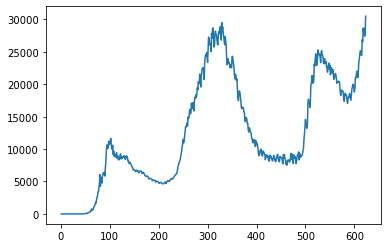

In [62]:
plt.plot(ru_new_cases['num_of_days'],abs(ru_new_cases['new_cases']))

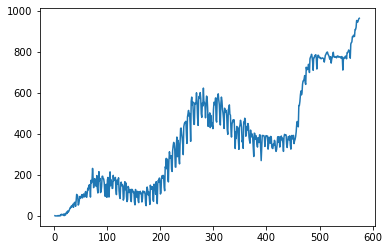

In [63]:
plt.plot(ru_new_death_cases['num_of_days'],abs(ru_new_death_cases['new_death_cases']))

#### Plotting a trend line for next one week prediction of new cases in Russia

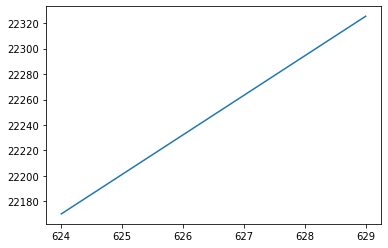

In [64]:
future_days_rs = calculate_future_days(ru_new_cases)
predict_newcases_russia = model1.predict(future_days_rs['num_of_days'])
plt.plot(future_days_rs['num_of_days'],predict_newcases_russia)

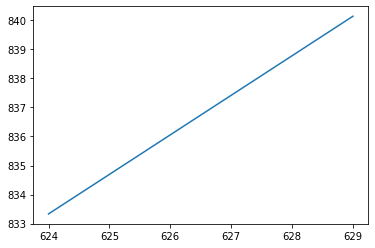

In [65]:
predict_newcases_rs_death = model_death1.predict(future_days_rs['num_of_days'])
plt.plot(future_days_rs['num_of_days'],predict_newcases_rs_death)

## Japan

In [66]:
japan_data = foreign_countries[foreign_countries["location"] == "Japan"].reset_index()

In [67]:
ja_first_death_case = generate_first_occurance_death(japan_data)
ja_first_death_case

,Date,new_death_cases,num_of_days
22,2020-02-13,1.0,1
23,2020-02-14,0.0,2
24,2020-02-15,0.0,3
25,2020-02-16,0.0,4
26,2020-02-17,0.0,5
...,...,...,...
627,2021-10-10,7.0,606
628,2021-10-11,20.0,607
629,2021-10-12,27.0,608
630,2021-10-13,33.0,609


In [68]:
ja_first_case = generate_first_occurance_case(japan_data)
ja_first_case

,Date,new_cases,num_of_days
4,2020-01-26,2.0,1
5,2020-01-27,0.0,2
6,2020-01-28,3.0,3
7,2020-01-29,0.0,4
8,2020-01-30,4.0,5
...,...,...,...
627,2021-10-10,549.0,624
628,2021-10-11,371.0,625
629,2021-10-12,613.0,626
630,2021-10-13,731.0,627


RMSE(Root Mean Square Error) value for the Linear model is:  3635.744919842425
RMSE(Root Mean Square Error) value for the Linear model is:  3533.166758004668
RMSE(Root Mean Square Error) value for the Linear model is:  3533.1197082457443
RMSE(Root Mean Square Error) value for the Linear model is:  3506.4146292710952
RMSE(Root Mean Square Error) value for the Linear model is:  3357.3902974694724


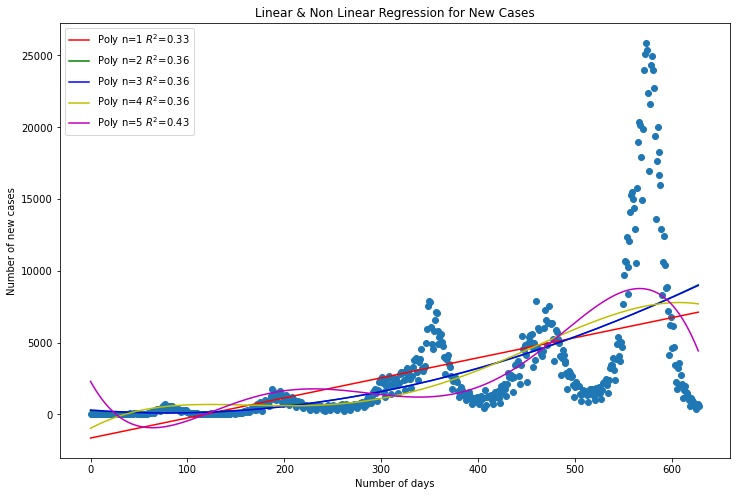

In [69]:
# Linear Regression for New cases
model1, y_pred1 = generate_model(1,ja_first_case,"new")
model2, y_pred2 = generate_model(2,ja_first_case,"new")
model3, y_pred3 = generate_model(3,ja_first_case,"new")
model4, y_pred4 = generate_model(4,ja_first_case,"new")
model5, y_pred5 = generate_model(5,ja_first_case,"new")

# Plotting figure
plt. figure(figsize=(12,8))
plt.scatter(ja_first_case['num_of_days'],abs(ja_first_case['new_cases']))
plt.plot(y_pred1,c='r',label='Poly n=1 $R^2$=%.2f' % model1.rsquared, alpha=1.0)
plt.plot(y_pred2,c='g',label='Poly n=2 $R^2$=%.2f' % model2.rsquared, alpha=1.0)
plt.plot(y_pred3,c='b',label='Poly n=3 $R^2$=%.2f' % model3.rsquared, alpha=1.0)
plt.plot(y_pred4,c='y',label='Poly n=4 $R^2$=%.2f' % model3.rsquared, alpha=1.0)
plt.plot(y_pred5,c='m',label='Poly n=5 $R^2$=%.2f' % model5.rsquared, alpha=1.0)
plt.title("Linear & Non Linear Regression for New Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of new cases")
plt.legend()
plt.show("png")

RMSE(Root Mean Square Error) value for the Linear model is:  27.534851742309723
RMSE(Root Mean Square Error) value for the Linear model is:  26.778355535719996
RMSE(Root Mean Square Error) value for the Linear model is:  24.931354942465077
RMSE(Root Mean Square Error) value for the Linear model is:  24.869623589329475
RMSE(Root Mean Square Error) value for the Linear model is:  23.194112449568888


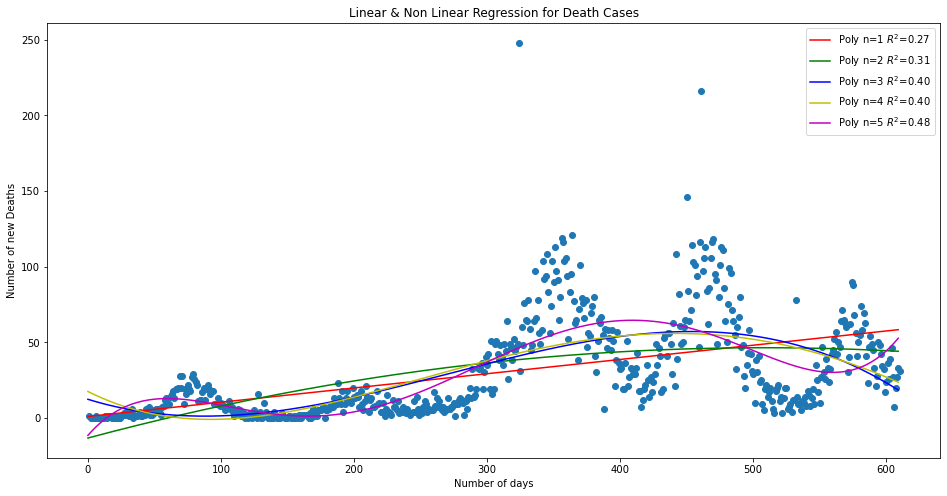

In [70]:
# Linear Regression for new deaths
model_death1, y_pred_d1 = generate_model(1,ja_first_death_case,"death")
model_death2, y_pred_d2 = generate_model(2,ja_first_death_case,"death")
model_death3, y_pred_d3 = generate_model(3,ja_first_death_case,"death")
model_death4, y_pred_d4 = generate_model(4,ja_first_death_case,"death")
model_death5, y_pred_d5 = generate_model(5,ja_first_death_case,"death")

# Plotting Figure
plt. figure(figsize=(16,8))
plt.scatter(ja_first_death_case['num_of_days'],abs(ja_first_death_case['new_death_cases']))
plt.plot(y_pred_d1,c='r',label='Poly n=1 $R^2$=%.2f' % model_death1.rsquared, alpha=1.0)
plt.plot(y_pred_d2,c='g',label='Poly n=2 $R^2$=%.2f' % model_death2.rsquared, alpha=1.0)
plt.plot(y_pred_d3,c='b',label='Poly n=3 $R^2$=%.2f' % model_death3.rsquared, alpha=1.0)
plt.plot(y_pred_d4,c='y',label='Poly n=4 $R^2$=%.2f' % model_death4.rsquared, alpha=1.0)
plt.plot(y_pred_d5,c='m',label='Poly n=5 $R^2$=%.2f' % model_death5.rsquared, alpha=1.0)
plt.title("Linear & Non Linear Regression for Death Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of new Deaths")
plt.legend()
plt.show("png")

#### Trend line for new cases and deaths in Russia

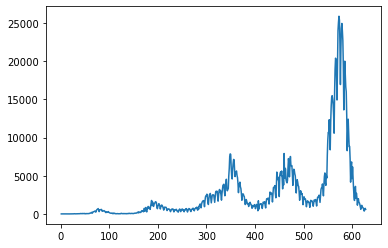

In [71]:
plt.plot(ja_first_case['num_of_days'],abs(ja_first_case['new_cases']))

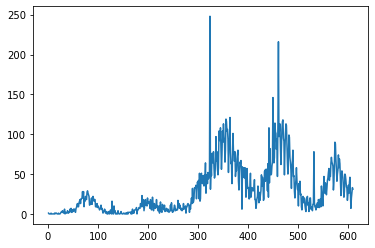

In [72]:
plt.plot(ja_first_death_case['num_of_days'],abs(ja_first_death_case['new_death_cases']))

#### Plotting a trend line for next one week prediction of new cases in Nigeria

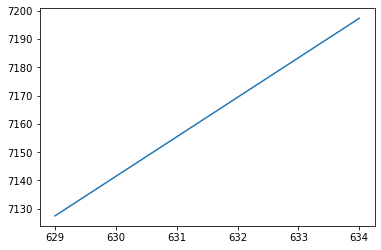

In [73]:
future_days_ja = calculate_future_days(ja_first_case)
predict_newcases_japan = model1.predict(future_days_ja['num_of_days'])
plt.plot(future_days_ja['num_of_days'],predict_newcases_japan)

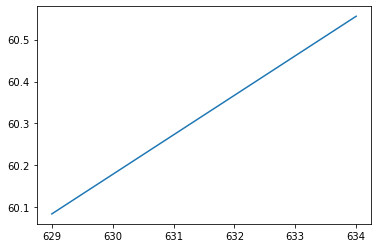

In [74]:
predict_newcases_ja_death = model_death1.predict(future_days_ja['num_of_days'])
plt.plot(future_days_ja['num_of_days'],predict_newcases_ja_death)

## Describe the trends of US compared to other countries:

When compared to other countries, the US is experiencing the most number of cases per day. 
But Russia is facing a higher number of death cases compared to all other states. 
Other than Russia and the US the other countries had peak cases at some point and the cases were reduced. 
Russia’s curve looks like it is trending upwards in cases and deaths. 
The cases and deaths for the country Nigeria is very low(maximum 80 deaths per day) when compared to other countries. 
In total, after the US, Brazil had the highest cases per day. 
Indonesia’s trend is almost flat for a year and then started increasing upto 55,000 cases per day and then suddenly dropped. 
Brazil’s new cases and deaths are pretty much scattered for the whole time. 
Japan’s highest case peak was in the last hundred days similarly it has highs and lows in its death rate as well.
